In [2]:
#Mounting the drive to link with the data
import os
from google.colab import drive
drive.mount('/content/gdrive')
print(os.listdir("/content/gdrive/My Drive/Thesis Earthquake Data/"))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
['EarthquakeDataR.csv', 'output.html', 'EarthquakeDataImp.csv', 'EarthquakeDataTime.csv', 'earthquake.csv', 'EarthquakeDataArima.csv', 'data.csv']


In [0]:
#Importing the necessary libraries
import pandas as pd
from sklearn import preprocessing
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#Importing the pre-processed data to save time with pandas.
EarthquakeDataImp = pd.read_csv('/content/gdrive/My Drive/Thesis Earthquake Data/EarthquakeDataImp.csv')
EarthquakeDataImp

In [0]:
#Removing the columns showing high correlation after Boruta by creating correlation matrix.
EarthquakeDataImp = EarthquakeDataImp.drop(['Unnamed: 0','EQID','T0.035S','Mo (dyne.cm)','Fault Rupture Width (km)','Dip (deg)','Depth to Top Of Fault Rupture Model'],axis=1)
EarthquakeDataImp

,Earthquake Magnitude,Strike (deg),Rake Angle (deg),Mechanism Based on Rake Angle,P-plunge (deg),P-trend (deg),T-plunge (deg),T-trend (deg),Fault Rupture Length for Calculation of Ry (km),Fault Rupture Area (km^2),T0.036S,CRjb.4,CRjb.5,Hypocenter_Depth_(KM)
0,6.0,268.0,160.0,0.0,2.9,316.30,24.60,225.00,16.2,68.1,0.211880,0.00,0.00,6.00
1,6.0,268.0,160.0,0.0,2.9,316.29,24.62,224.96,15.3,120.0,0.063570,1.14,1.14,6.00
2,5.8,196.2,0.0,0.0,0.0,151.20,0.00,61.20,8.9,74.3,0.041890,0.00,0.00,10.00
3,5.0,205.5,0.0,0.0,0.0,160.50,0.00,70.50,2.2,8.4,0.019835,0.00,23.58,16.00
4,5.5,35.0,0.0,0.0,0.0,350.00,0.00,260.00,4.4,25.0,0.126340,0.00,0.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21523,3.8,134.0,-178.0,0.0,11.3,357.90,8.50,89.60,1.1,1.0,0.000358,4.58,4.58,7.59
21524,3.8,134.0,-178.0,0.0,11.3,357.90,8.50,89.60,1.1,1.0,0.000544,4.58,4.58,7.59
21525,3.8,134.0,-178.0,0.0,11.3,357.90,8.50,89.60,1.1,1.0,0.000349,4.58,4.58,7.59
21526,3.8,134.0,-178.0,0.0,11.3,357.90,8.50,89.60,1.1,1.0,0.000270,4.58,4.58,7.59


In [0]:
#Scaling the features with min max to make all the features in similar numbers for fast execution of algorithm
scaler = preprocessing.MinMaxScaler()
EarthquakeDataImpscaled = scaler.fit_transform(EarthquakeDataImp)


In [0]:
#Creating a data frame.
EarthquakeDataImpscaled= pd.DataFrame(EarthquakeDataImpscaled)
EarthquakeDataImpscaled
#type(EarthquakeDataImpscaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.613035,0.744444,0.635514,0.0,0.032475,0.878855,0.282434,0.627503,0.051871,0.005333,0.058828,0.000000,0.000000,0.073845
1,0.613035,0.744444,0.635514,0.0,0.032475,0.878827,0.282664,0.627391,0.048917,0.009404,0.017650,0.057986,0.028529,0.073845
2,0.572301,0.545000,0.336449,0.0,0.000000,0.420117,0.000000,0.168846,0.027905,0.005820,0.011631,0.000000,0.000000,0.123240
3,0.409369,0.570833,0.336449,0.0,0.000000,0.445957,0.000000,0.194887,0.005909,0.000651,0.005507,0.000000,0.590090,0.197333
4,0.511202,0.097222,0.336449,0.0,0.000000,0.972492,0.000000,0.725506,0.013132,0.001953,0.035078,0.000000,0.000000,0.123240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21523,0.164969,0.372222,0.003738,0.0,0.126540,0.994443,0.097589,0.248369,0.002298,0.000071,0.000099,0.232960,0.114615,0.093480
21524,0.164969,0.372222,0.003738,0.0,0.126540,0.994443,0.097589,0.248369,0.002298,0.000071,0.000151,0.232960,0.114615,0.093480
21525,0.164969,0.372222,0.003738,0.0,0.126540,0.994443,0.097589,0.248369,0.002298,0.000071,0.000097,0.232960,0.114615,0.093480
21526,0.164969,0.372222,0.003738,0.0,0.126540,0.994443,0.097589,0.248369,0.002298,0.000071,0.000075,0.232960,0.114615,0.093480


In [0]:
#Mapping the Columns
EarthquakeDataImpscaled = EarthquakeDataImpscaled.rename(columns={ 0: 'Earthquake Magnitude', 1: 'Strike (deg)', 2: 'Rake Angle (deg)', 3: 'Mechanism Based on Rake Angle', 4: 'P-plunge (deg)', 5: 'P-trend (deg)', 6: ' P-plunge (deg)', 7: 'T-trend (deg)	'
                                                                  , 8: 'Fault Rupture Length for Calculation of Ry (km)', 9: 'Fault Rupture Area (km^2)', 10: 'T0.036S'
                                                                  , 11: 'CRjb.4', 12: 'CRjb.5', 13: 'Hypocenter_Depth_(KM)'})

In [0]:
#Squareroot transformation was performed for positivley skewed data.
EarthquakeDataImpscaledsqrt = np.sqrt(EarthquakeDataImpscaled)

In [0]:
EarthquakeDataImpscaledsqrt

,Earthquake Magnitude,Strike (deg),Rake Angle (deg),Mechanism Based on Rake Angle,P-plunge (deg),P-trend (deg),P-plunge (deg),T-trend (deg)\t,Fault Rupture Length for Calculation of Ry (km),Fault Rupture Area (km^2),T0.036S,CRjb.4,CRjb.5,Hypocenter_Depth_(KM)
0,0.782965,0.862812,0.797191,0.0,0.180208,0.937473,0.531445,0.792151,0.227753,0.073030,0.242544,0.000000,0.000000,0.271745
1,0.782965,0.862812,0.797191,0.0,0.180208,0.937458,0.531661,0.792080,0.221171,0.096974,0.132853,0.240802,0.168904,0.271745
2,0.756506,0.738241,0.580042,0.0,0.000000,0.648164,0.000000,0.410909,0.167049,0.076287,0.107845,0.000000,0.000000,0.351056
3,0.639819,0.755535,0.580042,0.0,0.000000,0.667800,0.000000,0.441460,0.076873,0.025514,0.074209,0.000000,0.768173,0.444221
4,0.714984,0.311805,0.580042,0.0,0.000000,0.986150,0.000000,0.851766,0.114595,0.044192,0.187291,0.000000,0.000000,0.351056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21523,0.406164,0.610100,0.061142,0.0,0.355724,0.997218,0.312392,0.498366,0.047938,0.008402,0.009962,0.482660,0.338548,0.305745
21524,0.406164,0.610100,0.061142,0.0,0.355724,0.997218,0.312392,0.498366,0.047938,0.008402,0.012285,0.482660,0.338548,0.305745
21525,0.406164,0.610100,0.061142,0.0,0.355724,0.997218,0.312392,0.498366,0.047938,0.008402,0.009833,0.482660,0.338548,0.305745
21526,0.406164,0.610100,0.061142,0.0,0.355724,0.997218,0.312392,0.498366,0.047938,0.008402,0.008651,0.482660,0.338548,0.305745


In [0]:
# split data into X and y
X = EarthquakeDataImpscaledsqrt.iloc[:,0:13]
Y = EarthquakeDataImpscaledsqrt.iloc[:,13]
# split data into train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)
# fit a lightGBM model to the data
model = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
model.fit(X_train, y_train)
# make predictions
expected_y  = y_test
y_pred = model.predict(X_test)

In [0]:
#Unscaling the data with inverse transform after models
scale=preprocessing.MinMaxScaler()
scale.min_,scale.scale_=scaler.min_[13], scaler.scale_[13]
y_pred_unscaled = scale.inverse_transform(y_pred.reshape(-1,1))
y_test_unscaled = scale.inverse_transform(y_test.values.reshape(-1,1))
X_test_unscaled = scale.inverse_transform(X_test.values.reshape(-1,1))

In [0]:
#R squared value of the model.
print(metrics.r2_score(expected_y, y_pred))

0.6057526830073696


In [0]:
#MAPE
c = (max(y_pred)) - (min(y_pred))
c

0.2894032442506723

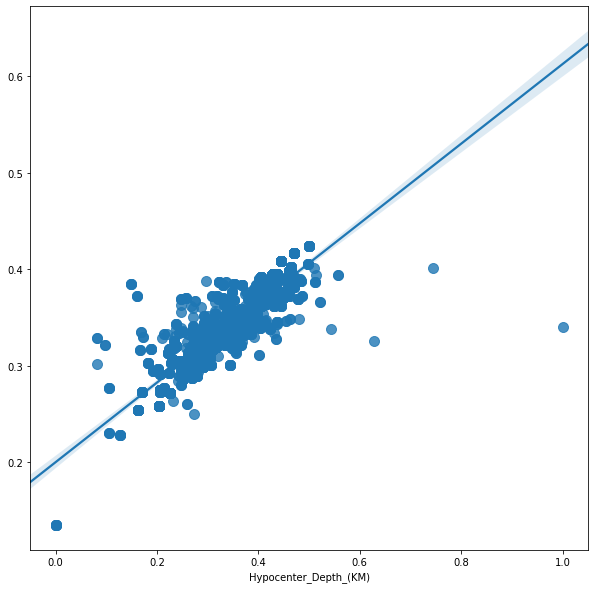

In [0]:
#plotting the best fit line.
plt.figure(figsize=(10,10))         
sns.regplot(expected_y, y_pred, fit_reg=True, scatter_kws={"s": 100})

In [0]:
##lgmBoost##
#Calculating the MAE, RMSE and MSE.
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_unscaled, y_pred_unscaled))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_unscaled, y_pred_unscaled))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_unscaled, y_pred_unscaled)))

Mean Absolute Error: 2.6244526347016284
Mean Squared Error: 13.167462618219647
Root Mean Squared Error: 3.6286998523189604


In [0]:
EarthquakeDataImpscaledsqrt.iloc[:,0:13]

In [0]:
print(min(y_pred_unscaled))
print(max(y_pred_unscaled))

[0.01595469]
[44.42004157]


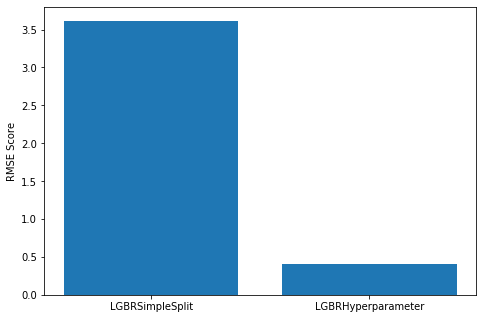

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['LGBRSimpleSplit', 'LGBRHyperparameter']
RMSE = [3.62,0.41]
ax.bar(Models,RMSE)
ax.set_ylabel('RMSE Score')
plt.show()

In [0]:
#hyper parameter tuning RandomizedSearchCV
#importing necessary liraries.
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
import lightgbm as lgb

#defining list of parameters.
n_estimators=[50,100,150,200]
max_features = ['auto','sqrt','log2']
max_depth =[4, 5, 8, -1]
num_leaves = [15, 31, 60, 90]
subsample = sp_uniform(0.6, 0.4)
colsample_bytree = sp_uniform(0.6, 0.4)
grid_param = {'n_estimators': n_estimators,
               'max_depth':  max_depth,
               'num_leaves': [15, 31, 60, 90],
               'subsample': subsample,
               'colsample_bytree': colsample_bytree 
               }
#Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(EarthquakeDataImpscaledsqrt.iloc[:,0:13],EarthquakeDataImpscaledsqrt['Hypocenter_Depth_(KM)'],test_size=0.2,random_state=123)
#Applying Random search
from sklearn.model_selection import RandomizedSearchCV
LGBMH = lgb.LGBMRegressor(random_state=1)
LGBMH_random = RandomizedSearchCV(estimator=LGBMH,param_distributions=grid_param,n_iter=500,cv=5,verbose=2,random_state=42,n_jobs=-1)
LGBMH_random.fit(X_train,y_train)
expected_y  = y_test
y_pred = LGBMH_random.predict(X_test)
#Printing the metrics
print(LGBMH_random.best_params_)
scale=preprocessing.MinMaxScaler()
scale.min_,scale.scale_=scaler.min_[13], scaler.scale_[13]
y_pred_unscaled = scale.inverse_transform(y_pred.reshape(-1,1))
y_test_unscaled = scale.inverse_transform(y_test.values.reshape(-1,1))
#print(LGBMH_random.best_score_)
print('RMSE is:')
print(np.sqrt(mean_squared_error(y_test_unscaled,y_pred_unscaled))) 
print('R2 is:')
print(r2_score(y_test_unscaled, y_pred_unscaled))
print('MAE is:')
print(mean_absolute_error(y_test_unscaled, y_pred_unscaled))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 10.8min finished


{'colsample_bytree': 0.7427013306774357, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 90, 'subsample': 0.7103996728090174}
RMSE is:
0.41759832562198446
R2 is:
0.994930008694481
MAE is:
0.08798857284601948


In [0]:
print(min(y_pred_unscaled))
print(max(y_pred_unscaled))

[0.01595469]
[44.42004157]
